- if a person spending more than 30% of income on housing, they live in an unaffordable home.
- Income data data is available from 2012-2020, and is uploaded in Kaggle. ([link](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1110024001))
- find out the average rental prices for cities, population and calculate population spending more than 30% on housing.

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
import plotly.express as px
import seaborn as sns
import functools
import math
import contextily as cx

pd.options.display.max_columns = 100

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
def plot_map(df, col, title=None, cbar_title=None, cmap='Blues', num_cols=6):
    years = df.year.sort_values().unique()
    fontsize = 24
    m = 2
    num_rows = math.ceil(len(years) / num_cols)
    fig, axes = plt.subplots(figsize=(m * 15, m * num_rows))
    vmin, vmax = df[col].agg(['min', 'max'])
    for idx, y in enumerate(years):
        df_year = df[df.year==y].sort_values('region')
        ax = plt.subplot(num_rows, num_cols, idx+1, xticks=[], yticks=[])
        df_year.plot(ax=ax, column=col, cmap=cmap, 
                     edgecolor='w', linewidth=1, 
                     vmin=vmin, vmax=vmax, 
                     missing_kwds={'color': 'w', 'edgecolor': 'lightgrey', 
                                   'linewidth': 1, 'label': 'Missing values'}, )
        annotation = ax.annotate(y, (.65, 1), xycoords='axes fraction', fontsize=fontsize)
        for pos in ['left', 'top', 'right', 'bottom']:
            ax.spines[pos].set_visible(False)

    plt.subplots_adjust(left=0, right=.85, top=1, bottom=0, hspace=0, wspace=0)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = plt.colorbar(sm, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    if cbar_title:
        cbar.ax.get_yaxis().labelpad = 35
        cbar.ax.set_ylabel(cbar_title, fontsize=1.4*fontsize, rotation=270)
    if title:
        fig.suptitle(title, y=1.1, fontsize=1.4*fontsize, ha='left')
    plt.show();

# Rental

In [3]:
provinces = {'alberta': 'Alberta', 
             'british_columbia': 'British Columbia', 
             'manitoba': 'Manitoba', 
             'new_brunswick': 'New Brunswick', 
             'newfoundland_and_labrador': 'Newfoundland and Labrador', 
             'nova_scotia': 'Nova Scotia', 
             'ontario': 'Ontario', 
             'prince_edward': 'Prince Edward Island', 
             'quebec': 'Quebec', 
             'saskatchewan': 'Saskatchewan'}
cma = {'abbotsford': 'Abbotsford - Mission', 
       'quebec_cma': 'Québec', 
       'barrie': 'Barrie', 
       'brantford': 'Brantford', 
       'calgary': 'Calgary', 
       'edmonton': 'Edmonton', 
       'gatineau': 'Ottawa - Gatineau (partie du Québec / Quebec part)', 
       'greater sudbury': 'Greater Sudbury / Grand Sudbury', 
       'guelph': 'Guelph', 
       'halifax': 'Halifax', 
       'hamilton': 'Hamilton', 
       'kingston': 'Kingston', 
       'moncton': 'Moncton', 
       'montreal': 'Montréal', 
       'oshawa': 'Oshawa', 
       'ottawa': "Ottawa - Gatineau (Ontario part / partie de l'Ontario)", 
       'peterborough': 'Peterborough', 
       'saguenay': 'Saguenay', 
       'saint_john': 'Saint John', 
       'saskatoon': 'Saskatoon', 
       'sherbrooke': 'Sherbrooke', 
       'sudbury': 'Greater Sudbury / Grand Sudbury', 
       'toronto': 'Toronto', 
       'thunder_bay': 'Thunder Bay', 
       'vancouver': 'Vancouver', 
       'victoria': 'Victoria', 
       'windsor': 'Windsor', 
       'winnipeg': 'Winnipeg'}

In [4]:
rental_path = '../input/housing-affordability-in-canada/housing-supply-price-rental.csv'
provinces_dbf = '../input/canada-shp/lpr_000a21a_e/lpr_000a21a_e.shp'
cma_dbf = '../input/canada-shp/lcma000a21a_e/lcma000a21a_e.shp'
rental = pd.read_csv(rental_path)

rental.drop(['Unnamed: 0'], axis=1, inplace=True)
rental.loc[(rental.region=='abbotsford') & (rental.year==1993), 'year'] = 1992
rental.loc[(rental.region=='abbotsford') & (rental.year==1993.1), 'year'] = 1993
rental.year = rental.year.astype('int')
rental.population = rental.population * 1000

rental['region_type'] = rental.region.apply(lambda row: 
                                        'province' if row in provinces.keys() else 'cma')
rental['region_name'] = rental.region.apply(lambda row: 
                                            provinces.get(row, cma.get(row, np.nan)))
def read_shp(shp_path, col, geoareas):
    gdf = gpd.read_file(shp_path)
    gdf = gdf.loc[gdf[col].isin(geoareas.values()), [col] + ['LANDAREA', 'geometry']]
    gdf.columns = gdf.columns.str.replace(col[:3], '').str.lower()
    return gdf.copy()
gdf_province = read_shp(provinces_dbf, 'PRENAME', provinces)
gdf_cma = read_shp(cma_dbf, 'CMANAME', cma)
gdf_total = pd.concat([gdf_province, gdf_cma])
rental = pd.merge(gdf_total, rental, how='right', left_on='name', right_on='region_name')
rental.to_crs(epsg=4326, inplace=True)

## the average rental prices in regions

In [5]:
rental_units = ['bachelor', 'one_bedroom', 'two_bedroom', 'three_bedroom']
rental[rental_units] = rental[rental_units].replace(-99, np.nan).fillna(method='pad')
rental[rental_units].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 944 entries, 0 to 943
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bachelor       944 non-null    float64
 1   one_bedroom    944 non-null    int64  
 2   two_bedroom    944 non-null    int64  
 3   three_bedroom  944 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 36.9 KB


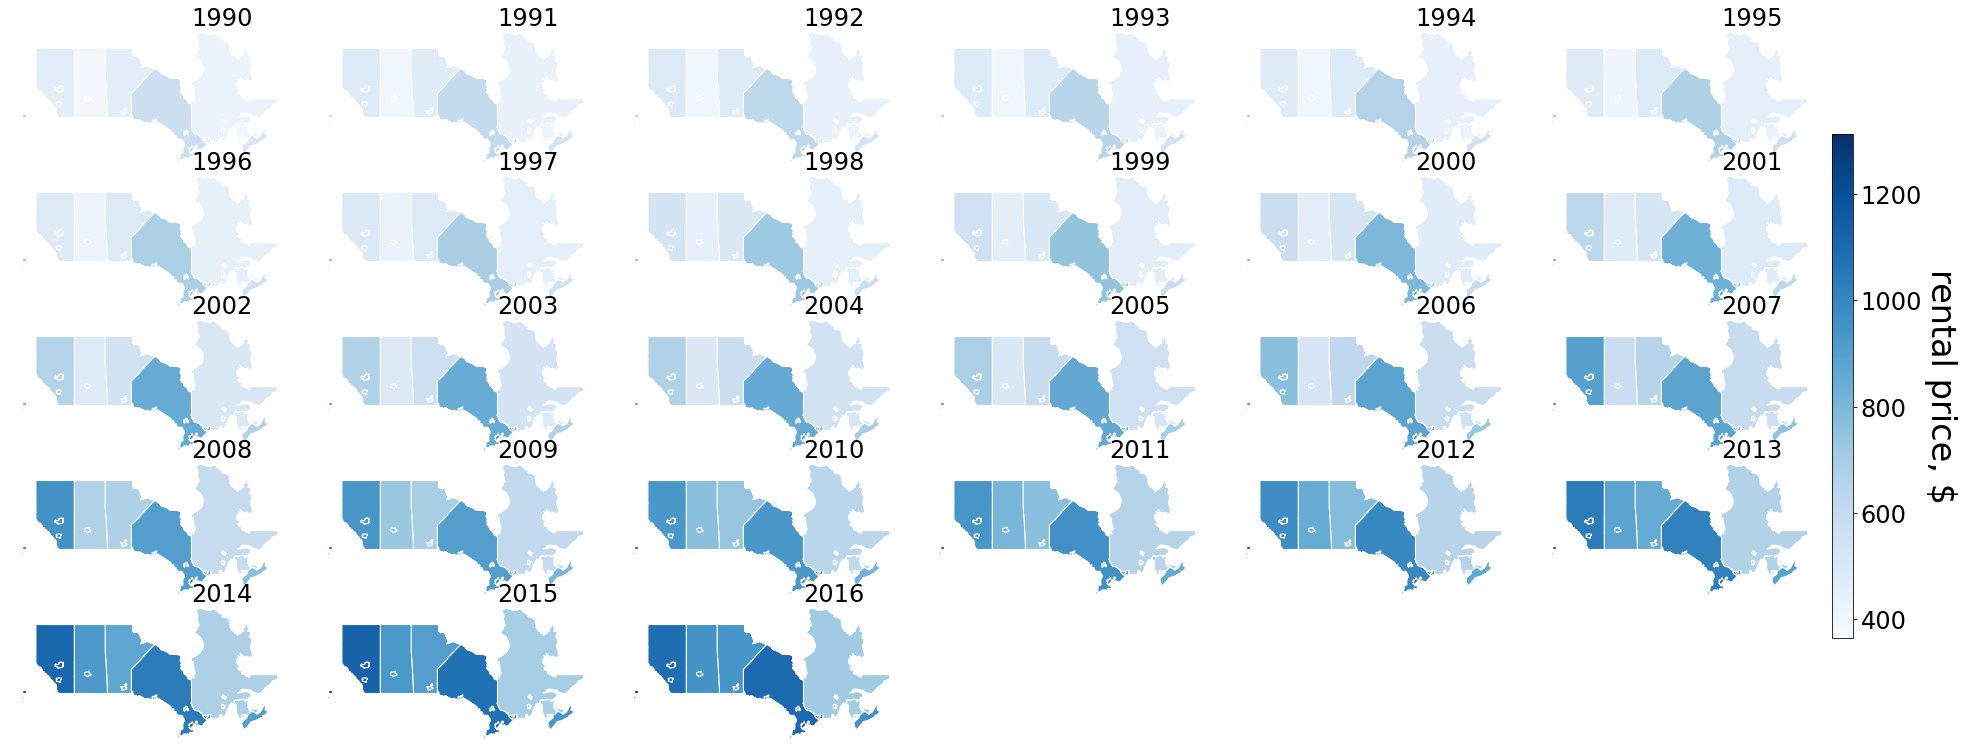

In [6]:
rental['avg_rent'] = rental[rental_units].mean(axis=1)
px.line(rental, x='year', y='avg_rent',
        color='region', labels={'avg_rent': 'Average rent, $', 
                                'year': ''}, 
        category_orders={'region': rental.region.sort_values().unique()}, 
        title='Average rental prices by regions', 
        width=800, height=500).show()
px.box(rental.sort_values('avg_rent'), x='region', y='avg_rent', 
        labels={'avg_rent': 'Average rent, $', 
                'region': ''}, 
        width=800, height=500).show()
plot_map(rental, 'avg_rent', cbar_title='rental price, $')

## the average population in regions

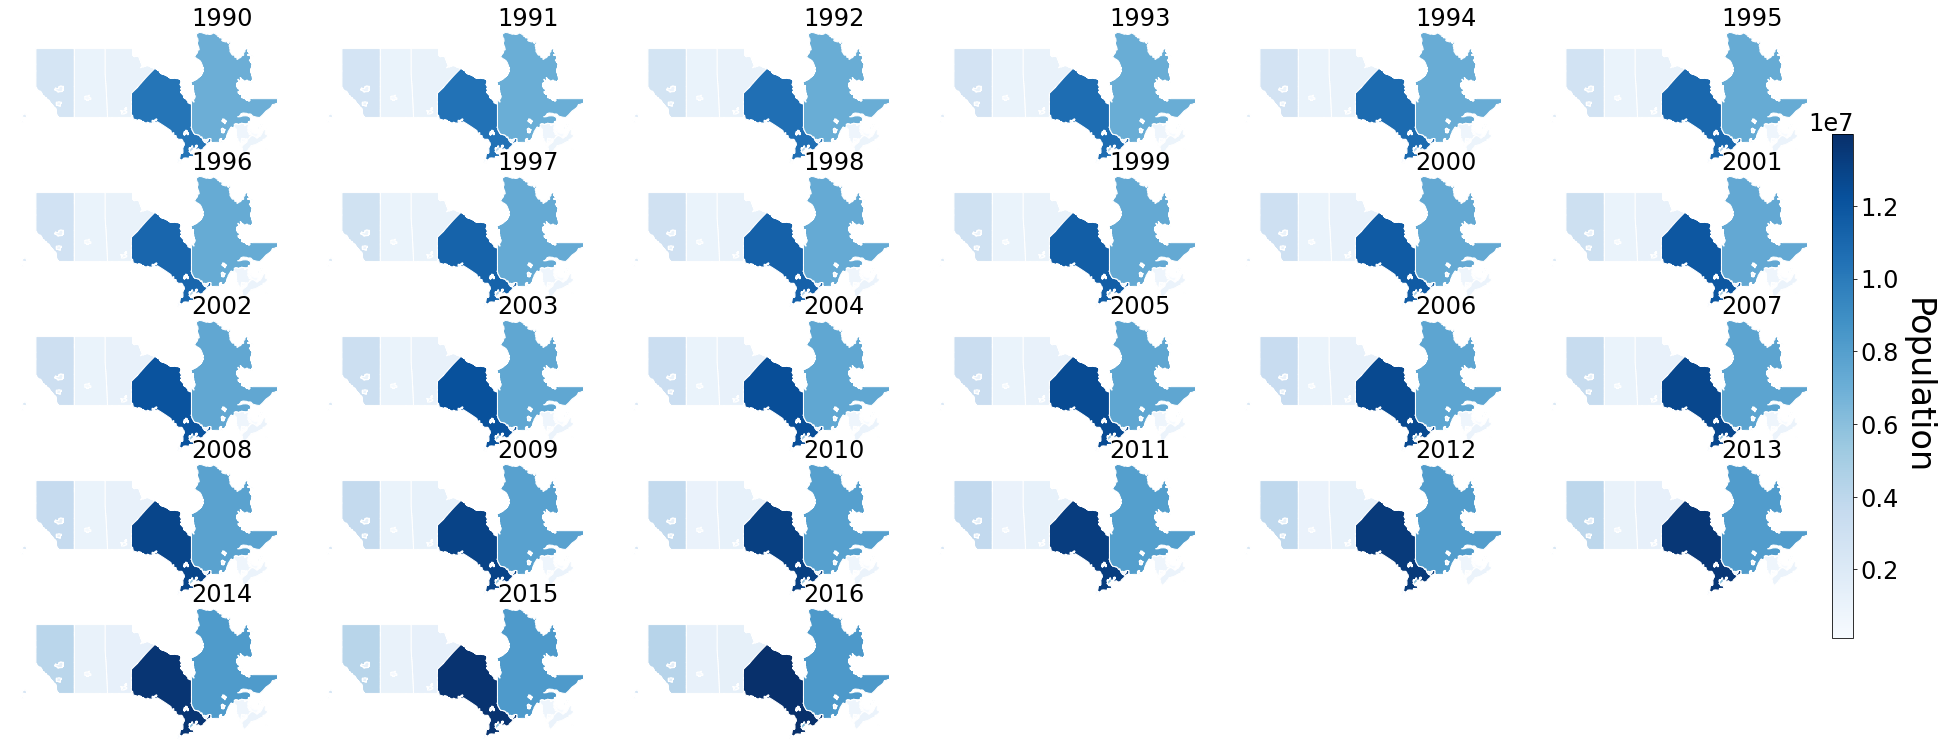

In [7]:
px.line(rental, x='year', y='population', 
        color='region', labels={'population': 'Population', 
                                'year': ''}, 
        category_orders={'region': rental.region.sort_values().unique()}, 
        title='Population by cities', 
        width=800, height=500).show()
px.box(rental.sort_values('population'), 
       x='region', y='population', 
       labels={'population': 'Population', 
               'region': ''}, 
        width=800, height=500).show()
plot_map(rental, 'population', cbar_title='Population')

# Income

In [8]:
income_region_path = '../input/canada-cma-income/1110024001_databaseLoadingData.csv'
income_region = pd.read_csv(income_region_path).dropna(axis=1)
to_drop = ['DGUID', 'Sex', 'Work activity', 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 
           'SCALAR_ID', 'VECTOR', 'COORDINATE', 'STATUS', 'DECIMALS']
income_region.drop(to_drop, axis=1, inplace=True)
income_region.columns = ['year', 'region', 'statistics', 'value']

income_region.region.unique()
region_map = {'Newfoundland and Labrador': 'newfoundland_and_labrador', 
            'Prince Edward Island': 'prince_edward', 
            'Nova Scotia': 'nova_scotia', 
            'New Brunswick': 'new_brunswick', 
            'Quebec': 'quebec', 
            'Ontario': 'ontario', 
            'Manitoba': 'manitoba', 
            'Saskatchewan': 'saskatchewan', 
            'Alberta': 'alberta', 
            'British Columbia': 'british_columbia', 
            'Québec, Quebec': 'quebec_cma', 
            'Montréal, Quebec': 'montréal', 
            'Ottawa-Gatineau, Ontario/Quebec': 'ottawa', 
            'Toronto, Ontario': 'toronto', 
            'Winnipeg, Manitoba': 'winnipeg', 
            'Calgary, Alberta': 'calgary', 
            'Edmonton, Alberta': 'edmonton', 
            'Vancouver, British Columbia': 'vancouver'}
income_region.region = income_region.region.map(region_map)

stats_map = {'Number of persons': 'population_with_income', 
            'Average employment income': 'avg_income',
            'Median employment income': 'median_income',
            'Percentage under $5,000 (including losses)': '<5000', 
            '$5,000 to $9,999': '5000-9999',
            '$10,000 to $19,999': '10000-19999', 
            '$20,000 to $29,999': '20000-29999', 
            '$30,000 to $39,999': '30000-39999',
            '$40,000 to $49,999': '40000-49999', 
            '$50,000 to $59,999': '50000-59999', 
            '$60,000 to $69,999': '60000-69999',
            '$70,000 to $79,999': '70000-79999', 
            '$80,000 to $89,999': '80000-89999', 
            '$90,000 to $99,999': '90000-99999',
            '$100,000 and over': '>100000'}
income_region.statistics = income_region.statistics.map(stats_map)

income_region = pd.pivot_table(income_region, values='value', index=['year', 'region'], 
                               columns='statistics')[stats_map.values()].reset_index()
income_region.population_with_income = income_region.population_with_income * 1000
income_region = rental[['geometry', 'name', 'year', 'region', 'bachelor', 
                        'one_bedroom', 'two_bedroom', 
                        'three_bedroom', 'avg_rent']].merge(income_region, how='inner', 
                                    on=['year', 'region'])

## population spending more than 30% on housing

In [9]:
income_region['avg_min_income'] = income_region['avg_rent'].div(.3)
vmin, vmax = income_region.avg_min_income.agg(["min", "max"])
print(f'Income range 30% of which is the average rental rate: ${vmin:.2f}-${vmax:.2f}')
income_region['population_rent>30'] = income_region['population_with_income'] * \
                                      income_region['<5000'] / 100
px.box(income_region.sort_values('<5000'), 
       x='region', y='<5000',
       labels={'region': '', 
               '<5000': 'Percentage of the population'},
       title='Percentage of the population that would spend<br>' \
             'more than 30% on average rent (upper bound)', 
      ).update_layout(yaxis_ticksuffix='%').show()
px.box(income_region.sort_values('population_rent>30'), 
       x='region', y='population_rent>30',
       labels={'region': '', 
               'population_rent>30': 'Population'},
       title='Population that would spend more than 30% on average rent (upper bound)', 
      ).show()

Income range 30% of which is the average rental rate: $2168.33-$4377.50
